In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.nn as nn
import data_utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams.update({'font.size': 12})
device

device(type='cuda')

In [3]:
DATA_DIR = '/datasets/cv_datasets/data'
ds_train = MNIST(root=DATA_DIR, download=True, train=True, transform=None)
ds_test = MNIST(root=DATA_DIR, download=True, train=False, transform=None)
dl_train, dl_val, dl_test = data_utils.get_data_loaders(train_dataset=ds_train, test_dataset=ds_test, batch_size=48)

In [4]:
from mnist import encoder

encoder = encoder.encoder_mnist()

projection_head = nn.Sequential(
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128)
)

model = nn.Sequential(
    encoder,
    projection_head
).to(device)

In [5]:
import training

try:
    encoder.load_state_dict(torch.load('saved_models/encoder_contrastive_mnist.pth'))
except:
        transform = transforms.Compose([
                transforms.RandomResizedCrop(28, scale=(0.5, 1.0)),
                transforms.RandomApply([
                        transforms.GaussianBlur(kernel_size=3)
                        ], p=0.5),
                ]) 

        
        num_epochs = 100
        # optimizer = torch.optim.SGD(
        #         model.parameters(),
        #         lr=6e-2,
        #         momentum=0.9,
        #         weight_decay=5e-4
        # )
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        contrastive_trainer = training.ContrastiveTrainer(model=model,
                                                          device=device,
                                                          num_epochs=num_epochs,
                                                          optimizer=optimizer,
                                                          transform=transform)
        contrastive_trainer.train(dl_train=dl_train, dl_val=dl_val)

        torch.save(encoder.state_dict(), 'saved_models/encoder_contrastive_mnist.pth')

/home/omer.trinin/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/omer.trinin/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/omer.trinin/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/omer.trinin/minicon

In [ ]:
from utils import plot_tsne

plot_tsne(model=encoder, dataloader=dl_test, device=device, name='contrastive_mnist')

In [6]:
from mnist import classifier

classifier = classifier.ClassifierMnist().to(device)
model = nn.Sequential(encoder, classifier).to(device)
loss_fn = torch.nn.CrossEntropyLoss()

In [7]:
for param in list(encoder.parameters()):
    param.requires_grad = False
for param in list(classifier.parameters()):
    param.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [8]:
DATA_DIR = '/datasets/cv_datasets/data'
ds_train = MNIST(root=DATA_DIR, download=True, train=True, transform=None)
ds_test = MNIST(root=DATA_DIR, download=True, train=False, transform=None)
dl_train, dl_val, dl_test = data_utils.get_data_loaders(train_dataset=ds_train, test_dataset=ds_test, batch_size=64)

--- EPOCH 1/20 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 844/844 [00:43<00:00, 19.30it/s]
Train loss: 0.15096761418232843, accuracy: 96.82995162162736
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:04<00:00, 20.08it/s]
Validation loss: 0.0706424771391965, accuracy: 98.23803191489361
Best model saved at epoch 1 with validation loss: 0.0706424771391965
--- EPOCH 2/20 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 844/844 [00:42<00:00, 19.99it/s]
Train loss: 0.09452227278175583, accuracy: 97.43841331434476
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

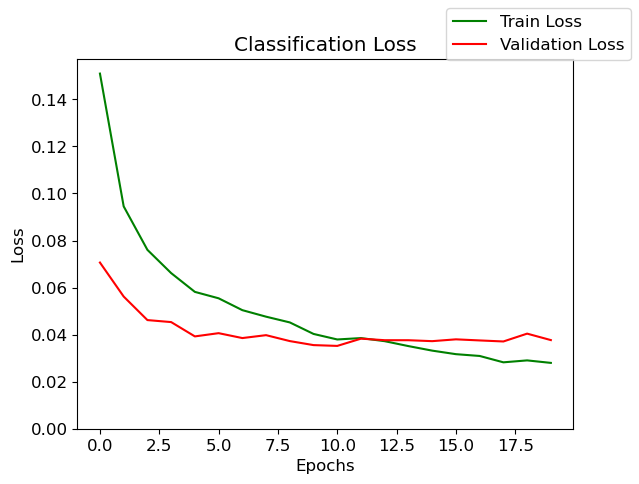

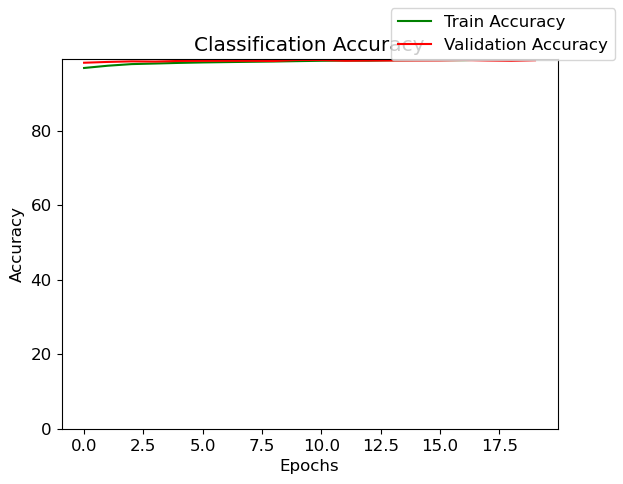

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 20.17it/s]
Test loss: 0.03558096767299005, accuracy: 98.88535031847134
Amazing!!!


In [10]:
import training

try:
    classifier.load_state_dict(torch.load('saved_models/classifier_contrastive_mnist.pth'))
except:
    classifier_trainer = training.ClassifierTrainer(model=model,
                                                optimizer=optimizer,
                                                loss_fn=loss_fn,
                                                device=device,
                                                transform=None)

    classifier_trainer.train(num_epochs=20,
                            dl_train=dl_train,
                            dl_val=dl_val)
    classifier_trainer.test(dl_test=dl_test)
    
    torch.save(classifier.state_dict(), 'saved_models/classifier_contrastive_mnist.pth')